In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
import torch.nn.functional as F
from models.last_layer_models import LLI, train_last_layer_det, get_post_pred_dens, LastLayerVIClosedForm
from models.hmc import log_posterior_horseshoe, HMC

from models.mc_dropout import MCDropoutNet
from models.bnn import BNN, train_bnn
from models.gibbs_sampler import gibbs_sampler, get_pred_post_dist, get_prediction_interval_coverage
from models.vi import  run_last_layer_vi_closed_form
from tqdm import tqdm
from utils.data_utils import create_synthetic_train_data, f

from utils.coverage import get_coverage_gaussian, get_coverage_y_hats

np.random.seed(100)

Text(0.5, 1.0, 'Training/Validation split')

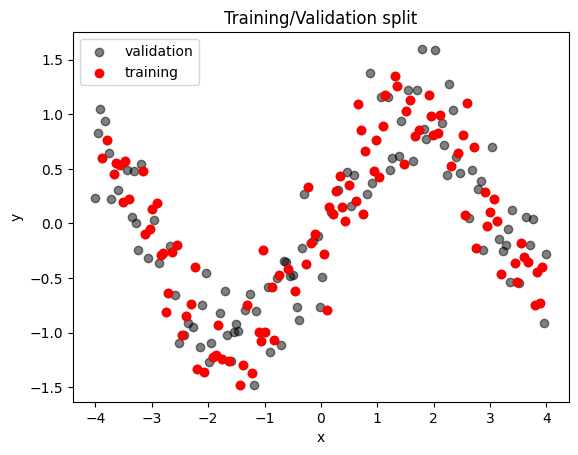

In [2]:
sigma_eps = 0.3
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = sigma_eps)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

In [4]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100
lli_net = LLI(model_dims)
sigma_0 = 0.3

100%|██████████| 100/100 [00:00<00:00, 166.54it/s]


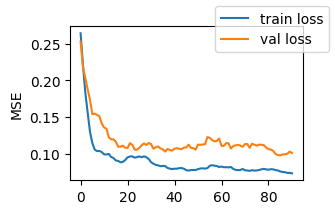

In [5]:
# train deep feature projector psi
lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [6]:
def pack_params(beta, lambda_j, sigma2):
    return torch.cat([beta, lambda_j, sigma2.unsqueeze(0)])

def unpack_params(x, L):
    beta = x[:L]
    lambda_j = x[L:2*L]
    sigma2 = x[-1]
    return beta, lambda_j, sigma2

def log_prob_flat(x):
    beta, lambda_j, sigma2 = unpack_params(x, L)
    # enforce positivity
    lambda_j = torch.clamp(lambda_j, min=1e-6)
    sigma2 = torch.clamp(sigma2, min=1e-6)
    return log_posterior_horseshoe(beta, lambda_j, sigma2)


In [7]:
with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

N, L = Psi.shape
softplus = torch.nn.Softplus()

In [8]:
def make_log_prob_flat(ys_train, Psi, tau_sq=1.0, a_sigma=2.0, b_sigma=2.0):
    L = Psi.shape[1]  # number of covariates

    def log_prob_flat(x):
        # unpack parameters
        beta = x[:L]
        lambda_j = x[L:2*L]
        sigma2 = x[-1]

        # enforce positivity
        #lambda_j = softplus(lambda_j) + 1e-4
        #sigma2 = softplus(sigma2) + 1e-4

        return log_posterior_horseshoe(
            ys_train, Psi, beta, L, sigma2, tau_sq, lambda_j, a_sigma, b_sigma
        )

    return log_prob_flat


In [9]:
Psi.shape

torch.Size([100, 50])

In [28]:
log_prob = make_log_prob_flat(ys_train, Psi, tau_sq=1)
hmc = HMC(dim=2*L+1, T=8000, L=15, step_size=torch.tensor(0.0001))
hmc.register_log_prob(log_prob)
# Initial state
x0 = torch.cat([torch.zeros(L), torch.zeros(L), torch.tensor([0.0])])

samples, accept_prob, accept_probs = hmc(x0)
print("Acceptance probability:", accept_prob)

100%|██████████| 8000/8000 [00:26<00:00, 306.97it/s]


Acceptance probability: tensor(0.6000)


In [29]:
def unpack_samples(samples, L):
    w_samples = samples[:, :L]
    lambda_samples = torch.exp(samples[:, L:2*L])
    sigma_eps_sq_samples = torch.exp(samples[:, -1])
    return w_samples, lambda_samples, sigma_eps_sq_samples

w_samples, lambda_samples, sigma_eps_sq_samples = unpack_samples(samples, L)


In [36]:
with torch.no_grad():
    Psi_val = lli_net.get_ll_embedd(xs_val)
pred_mu_samples = (Psi_val @  w_samples.T)
#var_pred = pred_mu_samples.var(dim=-1) + sigma_eps_sq_samples.mean()
#pred_std = torch.sqrt(var_pred)
pred_mu = pred_mu_samples.mean(dim = -1)

pred_std = torch.sqrt(((pred_mu_samples - pred_mu.unsqueeze(1))**2 + sigma_eps_sq_samples.unsqueeze(0)).mean(dim=-1))

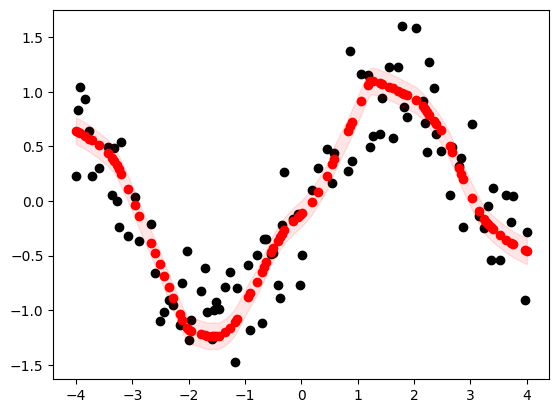

In [38]:
plt.scatter(xs_val, ys_val, color='black')
plt.scatter(xs_val, pred_mu, color='red')
plt.fill_between(xs_val.squeeze(), pred_mu - pred_std, pred_mu + pred_std, alpha = 0.1, color='red')